# Deep autoencoders for recommendations

In this notebook, we'll apply a more advanced algorithm to the same dataset as before, taking a different approach. We'll use a deep autoencoder network, which attempts to reconstruct its input and with that gives us ratings for unseen user / movie pairs.

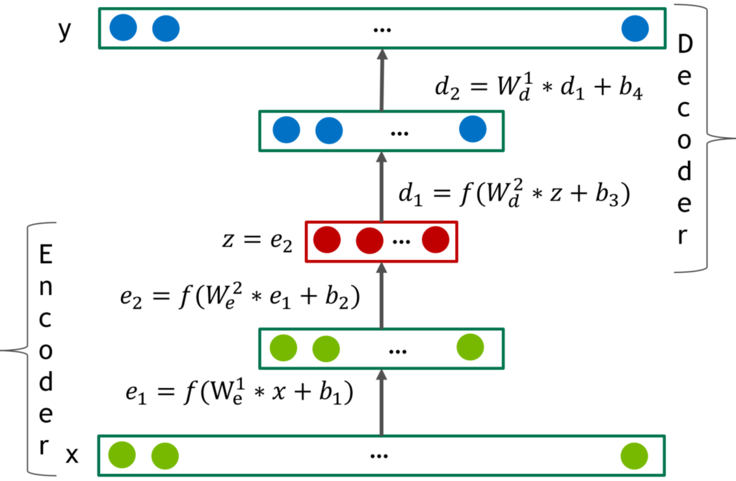

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [ ]:
# Clean up the logdir if it exists
import shutil
shutil.rmtree('logs', ignore_errors=True)

# Load TensorBoard extension for notebooks
%load_ext tensorboard

In [ ]:
movielens_ratings_file = 'https://github.com/janhartman/recsystf/raw/master/datasets/movielens_ratings.csv'
df = pd.read_csv(movielens_ratings_file)

user_ids = df['userId'].unique()
user_encoding = {x: i for i, x in enumerate(user_ids)}   # {user_id: index}
movie_ids = df['movieId'].unique()
movie_encoding = {x: i for i, x in enumerate(movie_ids)}

df['user'] = df['userId'].map(user_encoding)    # Map from IDs to indices
df['movie'] = df['movieId'].map(movie_encoding)

n_users = len(user_ids)
n_movies = len(movie_ids)

We're going to use the same dataset as before, but our preprocessing will be a bit different due to the difference in our model. Our autoencoder will take a vector of all ratings for a movie and attempt to reconstruct it. However, our input vector will have a lot of zeroes due to the sparsity of our data. We'll modify our loss so our model won't predict zeroes for those combinations - it will actually predict unseen ratings. 

To facilitate this, we'll use the sparse tensor that TF supports. Note: to make training easier, we'll transform it to dense form, which would not work in larger datasets - we would have to preprocess the data in a different way or stream it into the model.

In [ ]:
# Create a sparse tensor: at each user, movie location, we have a value, the rest is 0
x = tf.sparse.SparseTensor(indices=df[['movie', 'user']].values, values=df['rating'], dense_shape=(n_movies, n_users))

# Transform it to dense form and to float32 (good enough precision)
x = tf.cast(tf.sparse.to_dense(tf.sparse.reorder(x)), tf.float32)

# Shuffle the data
x = tf.random.shuffle(x, seed=42)

Now, let's create the model. We'll have to specify the input shape. Because we have 9724 movies and only 610 users, we'll prefer to predict ratings for movies instead of users - this way, our dataset is larger.

In [ ]:
n = n_users
inputs = layers.Input(shape=(n,))

class Encoder(layers.Layer):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.dense1 = layers.Dense(28, activation='selu', kernel_initializer='glorot_uniform')
        self.dense2 = layers.Dense(56, activation='selu', kernel_initializer='glorot_uniform')
        self.dense3 = layers.Dense(56, activation='selu', kernel_initializer='glorot_uniform')
        self.dropout = layers.Dropout(0.65)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dropout(x)
        
        
class Decoder(layers.Layer):
    def __init__(self, n, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.dense1 = layers.Dense(56, activation='selu', kernel_initializer='glorot_uniform')
        self.dense2 = layers.Dense(28, activation='selu', kernel_initializer='glorot_uniform')
        self.dense3 = layers.Dense(n, activation='selu', kernel_initializer='glorot_uniform')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

encoder = Encoder()
decoder = Decoder(n)

enc1 = encoder(inputs)
dec1 = decoder(enc1)
enc2 = encoder(dec1)
dec2 = decoder(enc2)

model = models.Model(inputs=inputs, outputs=dec2)
model.summary()

Because our inputs are sparse, we'll need to create a modified mean squared error function. We have to look at which ratings are zero in the ground truth and remove them from our loss calculation (if we didn't, our model would quickly learn to predict zeros almost everywhere).
We'll use masking - first get a boolean mask of non-zero values and then extract them from the result.

In [ ]:
def masked_mse(y_true, y_pred):
    mask = tf.not_equal(y_true, 0)
    se = tf.boolean_mask(tf.square(y_true - y_pred), mask)
    return tf.reduce_mean(se)

model.compile(
    loss=masked_mse,
    optimizer=keras.optimizers.Adam()
)

The model training will be similar as before - we'll use early stopping and TensorBoard. Our batch size will be smaller due to the lower number of examples. Note that we are passing the same array for both $x$ and $y$, because the autoencoder reconstructs its input.

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-2,
        patience=5,
        verbose=1,
    ),
    keras.callbacks.TensorBoard(log_dir='logs')
]

model.fit(x, 
          x, 
          batch_size=16, 
          epochs=100, 
          validation_split=0.1,
          callbacks=callbacks
)

Let's visualize our loss and the model itself with TensorBoard.

In [ ]:
%tensorboard --logdir logs

That's it! We've seen how to use TensorFlow to implement recommender systems in a few different ways. I hope this short introduction has been informative and has prepared you to use TF on new problems. Thank you for your attention!